This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


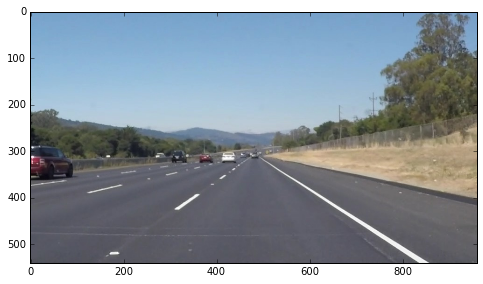

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

image = mpimg.imread('test_images/solidWhiteRight.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.figure(figsize=(8, 6))
plt.imshow(image);

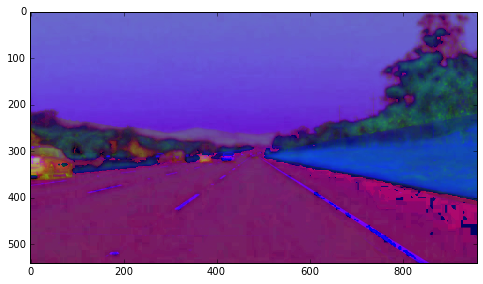

In [26]:
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
plt.figure(figsize=(8, 6))
plt.imshow(hsv);

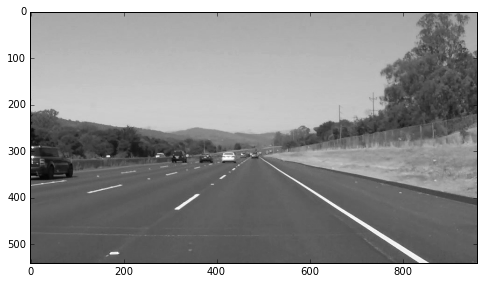

In [10]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(8, 6))
plt.imshow(gray, cmap='gray');

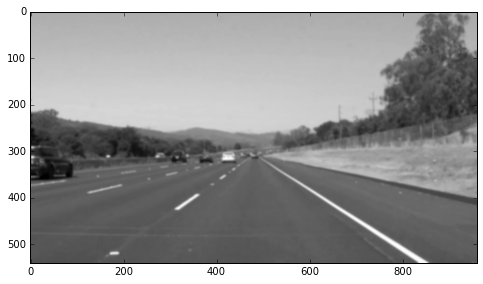

In [8]:
kernel_size = 9
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
plt.figure(figsize=(8, 6))
plt.imshow(blur_gray, cmap='gray');

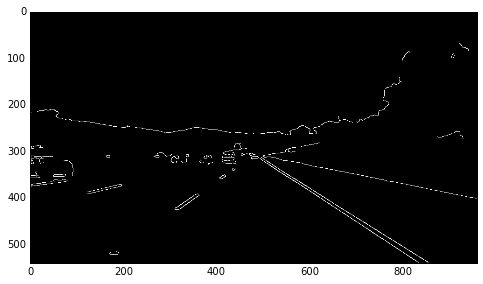

In [15]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.figure(figsize=(8, 6))
plt.imshow(edges, cmap='gray')

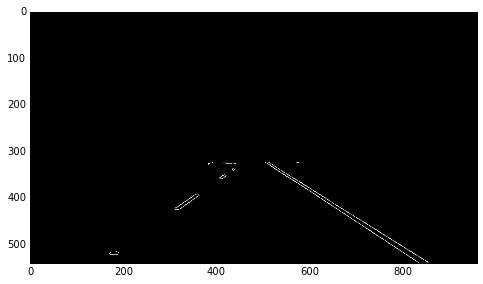

In [17]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from 'vertices'. The rest of the image is set to black.
    """
    # Defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

y_max = image.shape[0]
x_max = image.shape[1]
vertices = np.array([[(0,y_max),(x_max*2/5, y_max*3/5), 
                      (x_max*3/5, y_max*3/5), (x_max,y_max)]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.figure(figsize=(8, 6))
plt.imshow(masked_edges, cmap='gray');

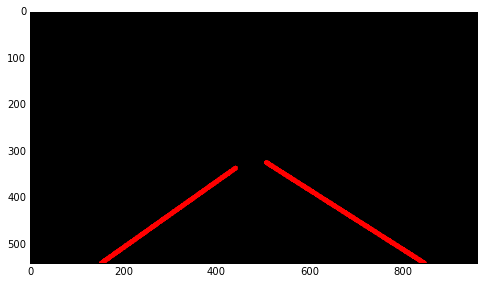

In [20]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws 'lines' with 'color' and 'thickness'.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # Create placeholders for slope(m) and intercept(b) for the left line and right line
    left_m = np.array([])
    left_b = np.array([])
    right_m = np.array([])
    right_b = np.array([])
    
    # Define the min value for y to find the top points for line drawing
    left_y_min = img.shape[0]
    right_y_min = img.shape[0]
    
    # Go through line by line
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Protect against "divide by zero"
            if(abs(x2 - x1) < 1e-3):
                continue
            # Get the slope and intercept of the current line
            m = (y2 - y1)/(x2 - x1)
            b = y2 - m * x2
            '''
            Check the slope range (experimental values) and 
            the intercept at the x=0 or x=x_max (lane line should 
            intercepts with the bottom of the frame, not side)
            '''
            # Left lane
            if(m <= -0.5 and m >= -0.9 and b >= img.shape[0]):
                # Save the slope and the intercept
                left_m = np.append(left_m, m)
                left_b = np.append(left_b, b)
                # Update the top point
                left_y_min = min(left_y_min, min(y1, y2))
            # Right lane
            elif(m >= 0.5 and m <= 0.9 and m*img.shape[1] + b >= img.shape[0]):
                # Save the slope and the intercept
                right_m = np.append(right_m, m)
                right_b = np.append(right_b, b)
                # Update the top point
                right_y_min = min(right_y_min, min(y1, y2))
            # Uncomment the next line to draw the "pre-processd" lines
            # cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], thickness)

    # If we found any lines
    if(len(left_m) > 0):
        # Get the average slope and intercept 
        left_avg_m = np.mean(left_m)
        left_avg_b = np.mean(left_b)
        # Get the x value for the top point
        left_x_min =  (left_y_min - left_avg_b) / left_avg_m
        # Get the x value for the bottom point (draw all the way to bottom)
        left_x_max =  (img.shape[0] - left_avg_b) / left_avg_m
        # Draw the left line
        cv2.line(img, (int(left_x_min), int(left_y_min)), (int(left_x_max), img.shape[0]), color, thickness)
    if(len(right_m) > 0):
        # Get the average slope and intercept 
        right_avg_m = np.mean(right_m)
        right_avg_b = np.mean(right_b)
        # Get the x value for the top point
        right_x_min = (right_y_min - right_avg_b) / right_avg_m
        # Get the x value for the bottom point (draw all the way to bottom)
        right_x_max = (img.shape[0] - right_avg_b) / right_avg_m
        # Draw the left line
        cv2.line(img, (int(right_x_min), int(right_y_min)), (int(right_x_max), img.shape[0]), color, thickness)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    'img' should be the output of a Canny transform.
    
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros([img.shape[0], img.shape[1], 3], dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


rho = 1
theta = np.pi/100
threshold = 30
min_line_len = 30
max_line_gap = 50

line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
plt.figure(figsize=(8, 6))
plt.imshow(line_image);


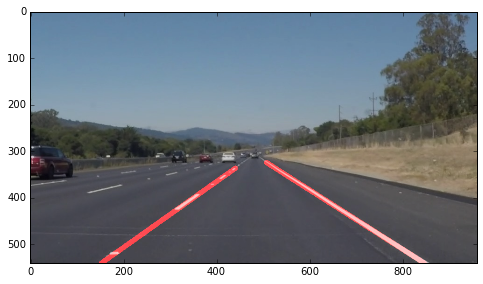

In [23]:
def weighted_img(img, initial_img, α=0.8, β=1.0, λ=0.0):
    """
    'img' is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    'initial_img' should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

lines_edges = weighted_img(line_image, image)
plt.figure(figsize=(8, 6))
plt.imshow(lines_edges);